# Communication System with Neural Network Decoder


![](/images/wirelessCommSystem.PNG) 

The figure above shows a diagram of a basic communication system with a wireless channel. The source first sends a message in bits which can be broken up into k length blocks and encoded using various coding schemes like Hamming, LDPC, or Random to output N length blocks. These blocks are then modulated through schemes like BPSK and QAM to send a waveform which goes through the channel. 

The channel response and noise impact the waveform and add errors to the sent bits. The demodulator and decoder are then required to convert the waveform to bits and convert the encoded bits back into the original message bits. The decoding error rate must be low enough to successfully send messages. Normally the demodulation and decoder have to be specially designed for the encoder, modulator, and channel. In this project, a neural network was used instead to do both demodulation and decoding.

![](/images/diagramNNdecoder.png) 

The image above shows the setup of the system ran using a Hamming encoder, binary phase shift keying (BPSK) Modulation, and an additive white guassian noise (AWGN) channel which adds white gaussian noise to the channel input. The demodulator and decoder have been replaced by a neural net with a 128-64-32 layer structure. It takes in N inputs corresponding to a BPSK modulated codeword with noise added and outputs k bits which should correspond to the message information bits. With a different modulation scheme the number of input bits to the network would be affected though the number output bits would not.

The signal can also be sent through an orthogonal frequency-division multiplexing (OFDM) module which has 32 carriers and a noisy channel with frequency response. A P/P block is added to take the modulation output from 7 parallel lines to 32. There is also another P/P block to transmit the 32 outputs of the OFDM module to 7 inputs to the Neural Network.

The neural network was trained by sending all possible codewords of length N through the system as an input with the corresponding k length information bits expected as an output. Additionally a random bitstream was sent through the system for training which greatly increases the performance of the network and is necessary for decoding if the signal is sent through the OFDM.

# OFDM Module

This module allows for the signal message to be sent through an OFDM channel before it enters the Neural Network Decoder. The OFDM sends the signal over different frequency sub carriers through a channel which has a finite impulse response and adds noise to the signal. A cyclic prefix is added to remove intersymbol interference. It should be of length L=9 but in this case it is tested with L=7 to see whether the neural network can account for the added inter symbol interference. 

In [3]:
class OFDM_module():
    def __init__(self, data,EbN0=5):
        self.OFDM_data = data
        self.K = 32
        self.CP = 7
        self.allCarriers = np.arange(self.K)
        self.channelResponse = np.array([1, 0, 0.3+0.3j,0.2-0.5j,0, 0.1j,-0.1+0.4j,0,0.2,-0.2j])
        #self.channelResponse = np.array([1]);#change!
        self.SNRdb = EbN0
        #self.SNRdb = 100;
    def IDFT(self, OFDM_data):
        return np.fft.ifft(OFDM_data)

    def addCP(self, OFDM_time):
        cp = OFDM_time[-self.CP:]
        return np.hstack([cp, OFDM_time])

    def channel(self, signal):
        convolved = np.convolve(signal, self.channelResponse)
        signal_power = np.mean(abs(convolved**2))
        sigma2 = signal_power * 10**(-self.SNRdb/10)
        noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
        return convolved + noise

    def removeCP(self, signal):
        return signal[self.CP:(self.CP+self.K)]

    def DFT(self, OFDM_RX):
        return np.fft.fft(OFDM_RX)

    def OFDM_run(self):
        OFDM_time = self.IDFT(self.OFDM_data)
        OFDM_withCP = self.addCP(OFDM_time)
        OFDM_TX = OFDM_withCP
        OFDM_RX = self.channel(OFDM_TX)
        OFDM_RX_noCP = self.removeCP(OFDM_RX)
        OFDM_demod = self.DFT(OFDM_RX_noCP)
        return OFDM_demod
    def setSNR(self,EbN0):
        self.SNRdb = EbN0;
    def getSNR(self):
        return self.SNRdb;


# NN Decoder Class

The NNdecoder class allows for creating a basic communication system model with a neural net used for demodulation and decoding.

## Parameters

The k value determines the information bit length used in the system. The training time increases exponentially with k since the network is trained on all $2^k$ possible codewords

The default is k=4

#### Channel
- The options are to send the signal through an AWGN channnel or the OFDM module. The AWGN channel only adds white guassian noise to the signal. The decoding works significantly better with the AWGN channel.

- The default is an AWGN channel

#### Encoder
- A Hamming encoder is used which can be adjusted by changing the value of j creating a code of size ($2^j-1-j,2^j-1$). The k value has to be divisible by $2^j-1-j$

- The default is a (4,7) Hamming code. 

#### Modulator

- The modulator sends the input bits through BPSK modulation which maps the 0 bits to -1 and the 1 bit to 1.

#### Neural Network

- The network parameters allow choosing if the network is also trained with a random bitstream and the length of that random bitstream. Training with a longer bitstream increases the training time but also increases the performance. The other parameters are batch size, number of epochs, optimizer type, loss type, and the metric.


- The metric choice is between the defined bermetric (found from the On Deep Learning Based Decoding paper referenced in citations) which uses the bit error rate as a metric or the already loaded 'accuracy'. The bermetric was found to give better performance which is expected since the metric we ultimately want to minimize is the bit error rate.


- The number of layers and epoch length can also be increased. Neither were found to improve performance significantly.


- If ```p=1``` then the data is trained on all possible codewords. If its is changed to a number less than 1 like 0.8, the network will be trained on only 80% of the codewords. This is to test whether the network is able to generalize and decode even untrained codewords. 


- The next parameter is the range and number of snrs the neural network is trained on. Increasing the number of snrs trained is one of the best ways to increase performance. The value of ```num_snr_tested``` determines the number of snrs trained.


- Mblocks determines the length of the random bitstream used for training (length is ```Mblocks*k```). Increasing Mblocks provides the greatest performance increase for the OFDM channel.


- M determines the length of the bitstream used for testing (```M*k```). Its default value of 10000 can be adjusted to get a more accurate BER estimate (especially important for high SNRs since the BER becomes very small with the AWGN channel)


- The default is  to train with ```Mblocks=50```, ```p=1```, ```batch size=10```, 100 epochs (results dont improve significantly with more epochs), binary cross entropy loss function, bermetric (gives best results), 128-64-32 network layers, and an snr range that goes from -2 db to 10 db with 20 SNR values tested and trained.


## Key Functions

```python
def createNNdecoder():     
    model = Sequential()#create model
    model.add(Dense(num_layers[0],input_dim=nn_input_size, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(num_layers[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(num_layers[2], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(nn_output_size, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer=m_optimizer,loss=m_loss,metrics=[m_metric])
    return model;
```

The createNN decoder function creates a simple neural network with 3 fully connected layers of default size 128-64-32. The input and output size are dependent on whether the channel is AWGN or OFDM. If the channel is AWGN the input is $N$ and the output is $k$. If the channel is OFDM and the modulation is BPSK, the input size is $2N$ since the OFDM module outputs a complex number which gets split into real and imaginary parts and then sent into the network. The output size is still $k$.

The output activation function is sigmoid which returns a value between 0 and 1 which can then be interpreted as a probability and used to hard decode (round output to 1 or 0)


```python 
def trainOverSNRs(self,plot_Convergence=False)
```
Trains the network using the current parameters over the SNR range. It trains over all codewords if ```p=1``` and trains over a random bitstream if ```train_w_bitstream=True```. If ```plot_Convergence``` is set to ```True```, the function will plot the bit error rate vs epochs for training.

```python
def sendThroughCommSystem(self,msg):
    #...
    return rec_msg;
```
Sends the input message bits through the the whole system (Encoder,Modulation,Channel,Neural Network) and returns the recieved message bits. 

```python
def testOverSNRs(self,M=10000):
```
Tests the system over the SNR range by sending a message of length $Mk$ using ```sendThroughCommSystem(self,msg)``` and finding the bit error rate for each SNR. 
If ```p!=1``` then the system will be tested with a stream composed only of untested codewords and a stream of only trained codewords for comparison.
The bit length M of the bistream to test has a default value of 10000. This can be increased to get a better estimate of the bit error rate or decreased to lower the running time.

```python
def run(self,plot_Convergence=False):
```
Runs the training and testing for the current parameters.

```python
def plotBER(self):
```
Plots the bit error rate. If ```p!=1``` the plot will include the bit error rate of untested codewords and trained codewords.



In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
import numpy as np
import sk_dsp_comm.fec_conv as fec
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.special as special
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.fec_block as block
from keras import backend as K
from sklearn.model_selection import train_test_split
from numpy.random import seed
from scipy.interpolate import spline
#seed(1)
from tensorflow import set_random_seed
import pyldpc;


class NNdecoder():
    def __init__(self,k=4,encoder_type='hamming',channel_type='AWGN',mod_type='BPSK',
                 train_w_bitstream=True,Mblocks=50,p=1,
                 m_batch_size=10,m_epochs=100,m_loss='binary_crossentropy',
                 m_metric='bermetric',num_layers=np.array([128,64,32]),
                 EbN0low=-2,EbN0high=10,num_snr_tested=20,M=10000):
        self.k = 4;
        self.encoder_type = encoder_type;
        self.channel_type = channel_type;
        self.mod_type = mod_type;
        self.train_w_bitstream = train_w_bitstream;
        self.Mblocks = Mblocks;
        self.p = p;
        self.m_batch_size = m_batch_size;
        self.m_epochs = m_epochs;
        self.m_loss = m_loss;
        self.m_metric = m_metric;
        self.num_layers = num_layers;
        self.EbN0low = EbN0low;
        self.EbN0high = EbN0high;
        self.EbN0 = EbN0low;
        self.num_snr_tested = num_snr_tested;
        self.snr_range = np.linspace(self.EbN0low,self.EbN0high,self.num_snr_tested);
        self.snr_train_range = np.linspace(self.EbN0low,self.EbN0high,self.num_snr_tested);
        self.m_optimizer = 'adam';
        self.M = M;
        #self.createNNdecoder();
        self.x_test = np.empty(1);
        self.y_test = np.empty(1);
        self.myOFDM = OFDM_module(self.x_test);
        self.num_carriers = self.myOFDM.K;
        self.initEncoder();
        self.createData();
        if(channel_type=='OFDM'):
            #nn_input_size = 32;
            self.nn_input_size = 2*self.N
            self.nn_output_size = self.k;
            #zero_pad = True;
        else:
            self.nn_input_size = self.N;
            self.nn_output_size = self.k;        
# =============================================================================
# Neural Network
# =============================================================================
    def bermetric(self,x, y):
        return K.mean(K.not_equal(x, K.round(y)));
    def createNNdecoder(self):     
        self.model = Sequential()#create model
        self.model.add(Dense(self.num_layers[0],input_dim=self.nn_input_size, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(self.num_layers[1], kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(self.num_layers[2], kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(self.nn_output_size, kernel_initializer='uniform', activation='sigmoid'))
        if(self.m_metric == 'accuracy'):
            self.model.compile(optimizer=self.m_optimizer, loss=self.m_loss, metrics=['accuracy'])
        else:
            self.model.compile(optimizer=self.m_optimizer, loss=self.m_loss, metrics=[self.bermetric]);
        return self.model;      
    def train(self):
        history = self.model.fit(self.x_train,self.y_train,batch_size=self.m_batch_size,epochs=self.m_epochs,verbose=False)
        return history;
    def test(self):
        predictions = self.model.predict(self.x_test);# returns probabilities
        output = np.round(predictions);
        ber = self.BER(self.y_test,output);
        return output,ber;
# =============================================================================
# Encoder 
# =============================================================================
    def initEncoder(self):
        self.j=3;
        if(self.encoder_type=='hamming'):
            n_hamm = 2**self.j - 1;
            k_hamm = n_hamm-self.j
            r = k_hamm/n_hamm
            self.N = np.int(self.k/r)
        if(self.encoder_type=='ldpc'):
            self.k=6;
            self.N,d_v,d_c = 15,4,5;
            self.H = pyldpc.RegularH(self.N,d_v,d_c)
            self.Gt = pyldpc.CodingMatrix(self.H);            

    def hamming_encode(self,bits):
        bits = np.int32(bits);
        hh1 = block.fec_hamming(self.j);
        
        y = hh1.hamm_encoder(bits)
        return y
    def Encoder(self,X):
        X = np.int32(X);
        Xnumrows = np.shape(X)[0]
        if (self.encoder_type == 'hamming'):
            enc = self.hamming_encode(np.ravel(X))
            return np.reshape(enc,(Xnumrows,self.N));
    
        if(self.encoder_type=='ldpc'):
            Xt = np.transpose(X);
            Yt = np.matmul(self.Gt,Xt);
            Y = np.transpose(Yt);
            Y = np.remainder(Y,2);
            return Y;
# =============================================================================
# Modulation
# =============================================================================
    def Modulation(self,x):
        if(self.mod_type == 'BPSK'):
            symbols1 = 2*x-1;
            symbols1 = np.ravel(symbols1);
        return symbols1;
# =============================================================================
# System
# =============================================================================
    def channelOutput(self,x):
         #orig_shape = x.shape
        x_flat = np.ravel(x)
        if(self.channel_type=='OFDM'):
            symbols = self.Modulation(x_flat);
            orig_symb_size = np.size(symbols);
            symbols = self.fit_to_input(x,self.num_carriers) 
            symb_rows = symbols.shape[0];
            self.myOFDM = OFDM_module(symbols[0,:]);
            self.myOFDM.setSNR(self.EbN0)
            y = self.myOFDM.OFDM_run()
            for i in range(1,symb_rows):
                self.myOFDM = OFDM_module(symbols[i,:])
                self.myOFDM.setSNR(self.EbN0)
                y = np.append(y,self.myOFDM.OFDM_run())
                y = np.ravel(y);
                y = y[0:orig_symb_size];
        else:
             y = dc.cpx_AWGN(2*x_flat-1,self.EbN0+10*np.log10(self.k/self.N),1);
    
        if((self.channel_type=='OFDM')):
            return y;
        else:
            return y.real;
        

    def sendThroughCommSystem(self,msg):
        num_msg_bits = msg.size;
        encodable = self.fit_to_input(msg,self.k);
        enc_out = self.Encoder(encodable);
        #enc_out = np.int32(enc_out);
        enc_out = np.ravel(enc_out);
        chan_out = self.channelOutput(enc_out);
             
        if(self.channel_type=='OFDM'):
            nn_input = self.fit_to_input(chan_out,np.int(self.nn_input_size/2));
            nn_input_complex = np.concatenate((nn_input.real,nn_input.imag),axis=1);
            nn_input = nn_input_complex;
        else:
            nn_input = self.fit_to_input(chan_out,self.nn_input_size);
        nn_out = self.model.predict(nn_input);
        rec_msg = np.round(nn_out);
        rec_msg = np.ravel(rec_msg);
        rec_msg = rec_msg[0:num_msg_bits]
            
        return rec_msg;
# =============================================================================
# Run Training and Tests
# =============================================================================
    def trainOverSNRs(self,plot_Convergence=False):
        print("Training...",end="");
        self.nn_ber = np.zeros(self.num_snr_tested)
        for i in range(self.num_snr_tested):
            self.EbN0 = self.snr_range[i];#increase SNR each time
            nn_input_og = self.channelOutput(self.cwords);
            nn_input = self.fit_to_input(nn_input_og,self.d.shape[0],1)
            fin_nn_in = nn_input;
            if(self.channel_type=='OFDM'):
                nn_input_complex = np.concatenate((nn_input.real,nn_input.imag),axis=1);
                fin_nn_in = nn_input_complex;
    
    
            if(i==0):
                self.nn_input_size = fin_nn_in.shape[1]
                self.nn_output_size = self.d.shape[1];
                self.model = self.createNNdecoder()#initialize decoder
                self.init_weights = self.model.get_weights();#get initial weights
            if(self.p!=1):#if data is going to be split into train and test sets
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(fin_nn_in, self.d, test_size=1-self.p,random_state=42,shuffle=True)
            else:
    
                self.x_train, self.x_test, self.y_train, self.y_test = fin_nn_in,fin_nn_in,self.d,self.d;
               # x_train, x_test, y_train, y_test = train_test_split(nn_input, dfit, shuffle=True,train_size=0.9999,test_size=0.9999)
    
            if(i==0):
                self.y_training = self.y_train;
                self.y_training = self.y_training[:,:,np.newaxis]
                self.y_testing = self.y_test;
                self.y_testing = self.y_testing[:,:,np.newaxis]
                self.x_testing = self.x_test;
                self.x_testing = self.x_testing[:,:,np.newaxis]
            else:
                self.y_training = np.append(self.y_training,np.expand_dims(self.y_train,axis=2),axis=2)
                self.y_testing = np.append(self.y_testing,np.expand_dims(self.y_test,axis=2),axis=2)
                self.x_testing = np.append(self.x_testing,np.expand_dims(self.x_test,axis=2),axis=2)
            cwordhist = self.train();#train with new output data
            if(plot_Convergence):
                plt.figure(1);
                metric_key =list(cwordhist.history.keys())[1]#get string of metric used
                plt.plot(cwordhist.history[metric_key]);
                plt.xlabel('Epochs');
                plt.ylabel('BER')
                plt.title(f'BER vs Epochs for Trained Codewords')
        if(self.train_w_bitstream):
            #nn_msg_ber = np.zeros(num_snr_tested)
            #Mblocks = 100; #number of k bit blocks to train
            for i in range(self.num_snr_tested):
                self.EbN0 = self.snr_range[i];
                if(self.p!=1):
                    msg_stream = self.createPermutationsOf(self.y_training[:,:,i],self.Mblocks)
                    rand_msg = msg_stream;
                else:
                    rand_msg = np.random.randint(0,2,self.k*self.Mblocks);
                dstream = np.reshape(rand_msg,(self.Mblocks,self.k))
                encodable = self.fit_to_input(rand_msg,self.k);
                enc_out = self.Encoder(encodable);
                #enc_out = np.int32(enc_out);
                enc_out = np.ravel(enc_out);
                nn_input_og = self.channelOutput(enc_out);
                nn_input = self.fit_to_input(nn_input_og,dstream.shape[0],1)
                fin_nn_in = nn_input;
                if(self.channel_type=='OFDM'):
                    nn_input_complex = np.concatenate((nn_input.real,nn_input.imag),axis=1);
                    fin_nn_in = nn_input_complex;
                if(i==0):
                    self.nn_input_size = fin_nn_in.shape[1]
                    self.nn_output_size = dstream.shape[1];
                    #model1 = createNNdecoder()#initialize decoder
                    self. init_weights = self.model.get_weights();#get initial weights

                self.x_train, self.x_test, self.y_train, self.y_test = fin_nn_in,fin_nn_in,dstream,dstream;
                   # x_train, x_test, y_train, y_test = train_test_split(nn_input, dfit, shuffle=True,train_size=0.9999,test_size=0.9999)
    
                bitstreamhist =self.train();#train with new output data
                if(plot_Convergence):
                    plt.figure(2)
                    metric_key =list(bitstreamhist.history.keys())[1]#get string of metric used
                    plt.plot(bitstreamhist.history[metric_key]);
                    plt.xlabel('Epochs');
                    plt.ylabel('BER')
                    plt.title(f'BER vs Epochs for Random Bitstream of Length {self.Mblocks*self.k}')
                #nn_ber[i]=test()[1];
        
        
    def testOverSNRs(self):
        #test bitstream
        print("Testing...",end="");
        self.nn_msg_ber = np.zeros(self.num_snr_tested)
        for i in range(self.num_snr_tested):
            self.EbN0 = self.snr_range[i];
            rand_msg = np.random.randint(0,2,self.k*self.M);
            rec_msg = self.sendThroughCommSystem(rand_msg);
            self.nn_msg_ber[i] = self.BER(rand_msg,rec_msg);
    
    
        if(self.p!=1):
        #test bitstream made only of untested codewords
            self.nn_testmsg_ber = np.zeros(self.num_snr_tested)
            for i in range(self.num_snr_tested):
                self.EbN0 = self.snr_range[i];
                test_msg_stream = self.createPermutationsOf(self.y_testing[:,:,i],self.k*self.M)
    
                test_rec_msg = self.sendThroughCommSystem(test_msg_stream);
                self.nn_testmsg_ber[i] = self.BER(test_msg_stream,test_rec_msg);
    
    
    
            #test bitstream made only trained codewords
            self.nn_trainmsg_ber = np.zeros(self.num_snr_tested)
            for i in range(self.num_snr_tested):
                self.EbN0 = self.snr_range[i];
                train_msg_stream = self.createPermutationsOf(self.y_training[:,:,i],self.k*self.M)
                train_rec_msg = self.sendThroughCommSystem(train_msg_stream);
                self.nn_trainmsg_ber[i] = self.BER(train_msg_stream,train_rec_msg);  
        print("Complete");
        
    def plotBER(self):
        if(self.p!=1):
            #n1, = plt.plot(snr_range,nn_ber);
            
            n2, = plt.plot(self.snr_range,self.nn_msg_ber)
            m1, = plt.plot(self.snr_range,self.map_ber)
            n3, = plt.plot(self.snr_range,self.nn_testmsg_ber)
            n4, = plt.plot(self.snr_range,self.nn_trainmsg_ber)
             #plt.plot(snr_range,map_ber2)
            plt.yscale('log')
            plt.ylabel('BER')
            plt.xlabel('SNR(dB)')
            title = f"BER vs SNR for {self.channel_type} k={self.k} N={self.N} p={self.p} with {self.encoder_type} encoding, {self.num_snr_tested} SNRs trained, {self.m_epochs} Epochs"
            plt.title(title)
            plt.legend([n2,n3,n4,m1],['Neural Net Decoder','NN:Test Codewords','NN:Trained Codewords','MAP'])
    
        else:
            n2, = plt.plot(self.snr_range,self.nn_msg_ber)
            m1, = plt.plot(self.snr_range,self.map_ber)
            plt.yscale('log')
            plt.ylabel('BER')
            plt.xlabel('SNR(dB)')
            if(self.train_w_bitstream):
                title = f"BER vs SNR for {self.channel_type} k={self.k} N={self.N} w/{self.num_snr_tested} SNRs trained w/Bitstream of length {self.Mblocks*self.k}"
            else:
                 title = f"BER vs SNR for {self.channel_type} k={self.k} N={self.N} w/{self.num_snr_tested} SNRs trained w/o Bitstream"
            plt.title(title);
            plt.legend([n2,m1],['Neural Net Decoder','MAP'])
    def run(self,plot_Convergence=False):
        self.MAPdecodertest()
        self.trainOverSNRs(plot_Convergence);
        self.testOverSNRs();
    def MAPdecodertest(self,coded=True):    
        self.map_ber = block.block_single_error_Pb_bound(self.j,self.snr_range,coded);
# =============================================================================
# Helper Functions
# =============================================================================
    def BER(self,x,y):
        return np.mean(np.not_equal(x,y))
    def printParameters(self):
        if(self.train_w_bitstream):
            parameters = f'Channel is {self.channel_type}\n{self.encoder_type} encoder with k={self.k}, N=7\n{self.num_snr_tested} SNRs trained\nBitstream of length {self.Mblocks*self.k} is trained\n{self.num_layers} layer type,{self.m_epochs} epochs\np={self.p}'
        else:
            parameters = f'Channel is {self.channel_type}\n{self.encoder_type} encoder with k={self.k}, N=7\n{self.num_snr_tested} SNRs trained\nBitstream not used for training\n{self.num_layers} layer type,{self.m_epochs} epoch\np={self.p}'
        print(parameters);
    def fit_to_input(self,arr,in_len,axis=0):
        if(axis==0):
            if(arr.size%in_len==0):
                return arr.reshape((np.int(arr.size/in_len),in_len));
            else:
                return np.resize(arr,(np.int(arr.size/in_len)+1,in_len));
        if(axis==1):
            if(arr.size%in_len==0):
                return arr.reshape(in_len,(np.int(arr.size/in_len)));
            else:
                return np.resize(arr,(in_len,np.int(arr.size/in_len)+1));
    def createData(self):
        self.d = np.zeros((2**self.k,self.k))
        j=0
        #find all possible binary numbers of length k
        from itertools import product
        for i in product([0,1], repeat=self.k):
            self.d[j,:] = i;
            j=j+1; 
        self.cwords=np.zeros((2**self.k,self.N));
        self.d = np.int32(self.d);#make d integer
       # for p in range(0,2**k):
       #    cwords[p,:] = Encoder(d[p,:]) #find all possible codewords
        self.cwords = self.Encoder(self.d);
    def createPermutationsOf(self,words,num_chosen=200):
        num_testwords = np.shape(words)[0]
        #word_length = np.shape(words)[1]
        test_choices = np.random.randint(0,num_testwords,num_chosen)
        chosen = words[test_choices[0]]
        for i in range(1,num_chosen):
            chosen = np.append(chosen,words[test_choices[i]]);
         
        return chosen;    
    #Convert recieved bits to message
    def text_from_bits(self,bits):
        n = int(''.join(map(str, bits)), 2)
        return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()
    #Convert message string to bits
    def text_to_bits(self,text):
        bits = bin(int.from_bytes(text.encode(), 'big'))[2:]
        return np.asarray(list(map(int, bits.zfill(8 * ((len(bits) + 7) // 8)))),dtype=int)
    def sendStringMessage(self,msg_str,sendEbN0=10):
        #my_str = np.loadtxt("Input_150_039.txt")
        #send_msg_str = "Big Test this to work right now blah";
        send_msg_str = msg_str
        self.EbN0 = sendEbN0;
        msg_bits = self.text_to_bits(send_msg_str);
        rec_msg_bits = self.sendThroughCommSystem(msg_bits);
        str_ber = self.BER(msg_bits,rec_msg_bits);
        rec_msg_bits = np.int32(rec_msg_bits)
        print(f'Total Message Bits = {msg_bits.size}')
        print (f'Bit Errors = {str_ber*msg_bits.size}\n')
        
        rec_msg_str = self.text_from_bits(rec_msg_bits);
        
        
        print("Transmitted:")
        print(send_msg_str)  
        print("\nRecieved:")
        print(f'{rec_msg_str}\n')  

Using TensorFlow backend.


# Analysis

Tests are now done over the Neural Net Decoder to analyze its performance. The first set of tests use the AWGN channel.

### BER vs Epochs

We first test how the bit error rate converges with more epochs. The number of epochs is set to 200.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Testing...Complete


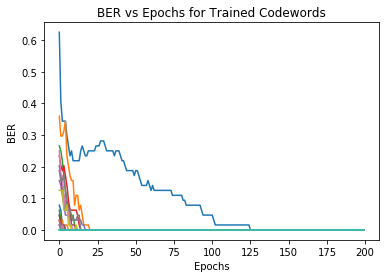

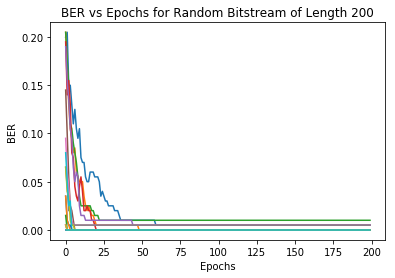

In [4]:
moreEpochs = NNdecoder(m_epochs=200);
moreEpochs.run(True);

Each different colored line represents a different SNR trained. For most of the SNRs the BER converges to its lowest value (close to zero) to within 100 epochs suggesting more epochs will not increase performance. The BER rate decreases with each new SNR used for training as expected. The default value of 100 epochs is used here on out to lower training time.

### Increase Length of Bitstream Trained

The network is now trained without the bitstream and then with different bitstream lengths by changing ```Mblocks```

In [58]:
%%time
testNoBitStream = NNdecoder(train_w_bitstream=False,M=70000);#default number of blocks
testNoBitStream.run();

Training...Testing...Complete
Wall time: 58.7 s


In [6]:
%%time
testBitStream1 = NNdecoder(train_w_bitstream=True,Mblocks=100,M=70000);
testBitStream1.run()

Training...Testing...Complete
Wall time: 54.9 s


In [7]:
%%time
testBitStream2 = NNdecoder(train_w_bitstream=True,Mblocks=200,M=70000);
testBitStream2.run();

Training...Testing...Complete
Wall time: 1min 22s


In [8]:
%%time
testBitStream3 = NNdecoder(train_w_bitstream=True,Mblocks=400,M=70000);
testBitStream3.run();

Training...Testing...Complete
Wall time: 1min 57s


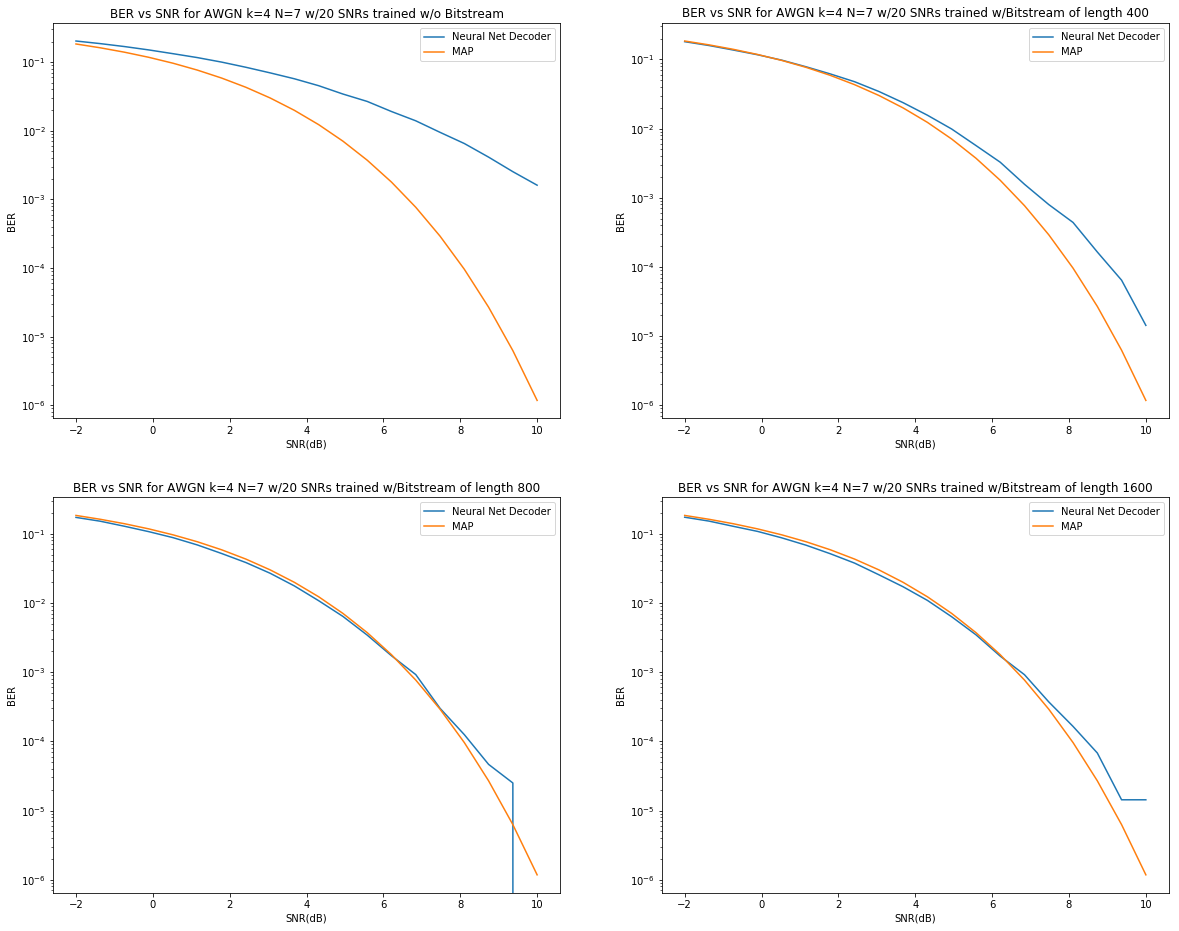

In [9]:
fig = plt.figure(figsize=(20,16))
plt.subplot(221);
testNoBitStream.plotBER()
plt.subplot(222)
testBitStream1.plotBER();
plt.subplot(223)
testBitStream2.plotBER();
plt.subplot(224)
testBitStream3.plotBER();

The bit error rate dropping to zero in the bottom left graph is an artifact resulting from the fact that the test message length was not large enough to get an accurate estimate of the actual bit error rate.

### Increase number of SNRs trained

The network is trained with different values of ```num_snr_tested``` and a bitstream of length 200

In [14]:
%%time
lowNumSNR = NNdecoder(num_snr_tested=20,M=70000);
lowNumSNR.run();

Training...Testing...Complete
Wall time: 46.7 s


In [11]:
%%time
medNumSNR = NNdecoder(num_snr_tested=40,M=70000)
medNumSNR.run();

Training...Testing...Complete
Wall time: 1min 16s


In [12]:
%%time
highNumSNR = NNdecoder(num_snr_tested=80,M=70000)
highNumSNR.run();

Training...Testing...Complete
Wall time: 2min 30s


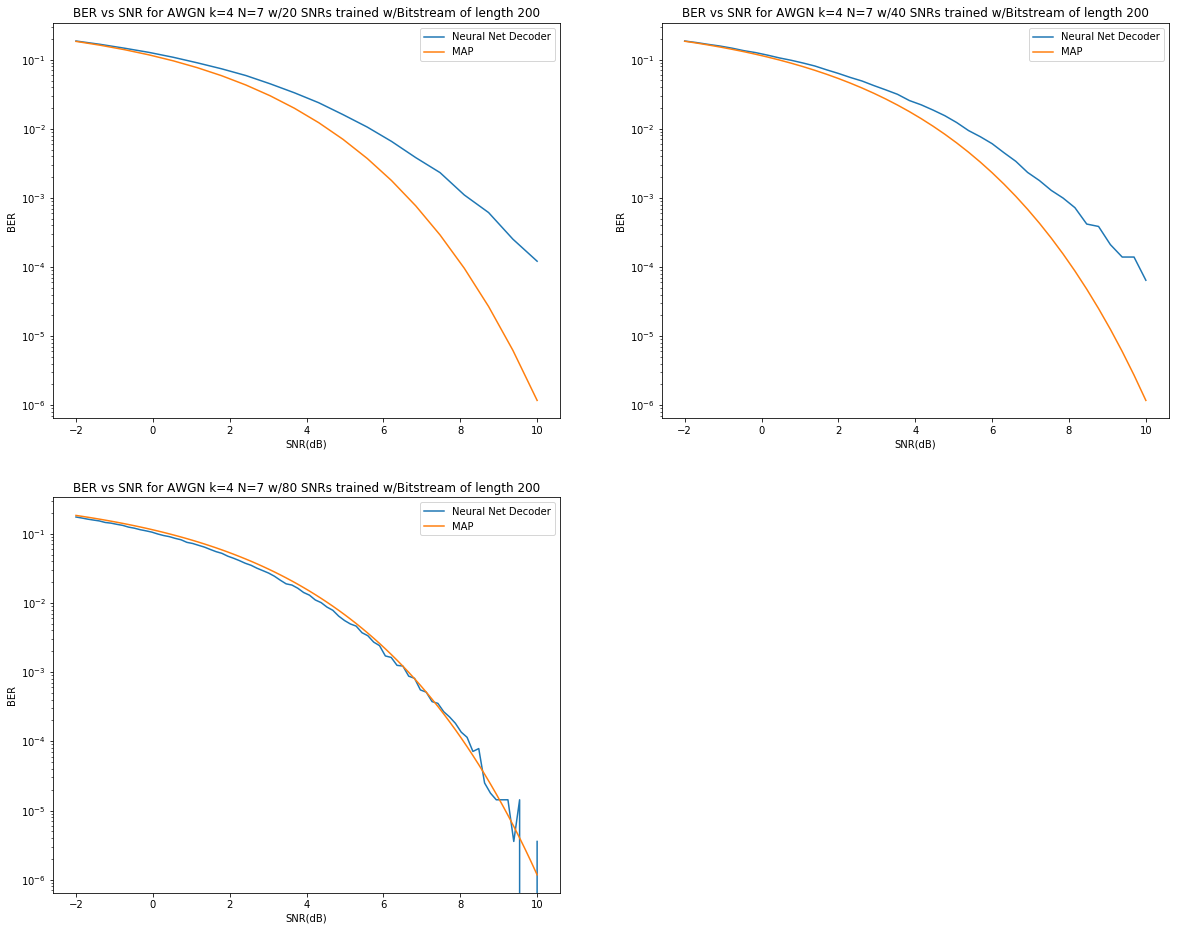

In [15]:
fig = plt.figure(figsize=(20,16))
plt.subplot(221);
lowNumSNR.plotBER();
plt.subplot(222)
medNumSNR.plotBER();
plt.subplot(223)
highNumSNR.plotBER();

As the graphs show, using a high number of ```Mblocks``` or testing many SNRs both lead to the neural net decoder achieving a BER very close to the optimal MAP bit error rate. 


Increasing the value of ```Mblocks``` appears to have dminishing returns since the test with ```Mblocks=200```  had a performance very close the test with ```Mblocks=400``` (Bitstream length = ```Mblocks*k```). 
Increasing the number of SNRs trained has a greater impact on the training time.

### Highest Training

The network is now trained with a high value of ```Mblocks``` and ```num_snr_tested```

In [23]:
%%time
combineDecoder = NNdecoder(Mblocks=200,num_snr_tested=80,M=70000)
combineDecoder.run();

Training...Testing...Complete
Wall time: 5min 37s


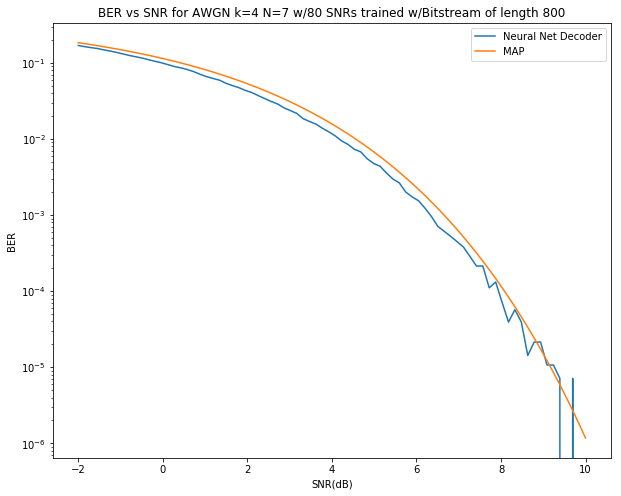

In [30]:
fig = plt.figure(figsize=(10,8))
combineDecoder.plotBER();

With these parameters, the network decoding appears to be slightly better than MAP decoding. This could be an artifact like before with the test message not being large enough to get an accurate estimate of the neural net decoders actual bit error rate.

## Generalizability

To test whether the neural network can actually learn the encoding algorithm it can be trained on a subset of the codewords and then tested on the remaining set of the codewords to see if it decodes even untrained codewords.

The tests are ran with ```p=0.8``` (80% of the codewords are trained) and ```p=0.9``` (90% of the codewords are trained).

In [31]:
%%time
subsetCodewords1 = NNdecoder(p=0.8);
subsetCodewords1.run();

Training...Testing...Complete
Wall time: 1min 53s


In [32]:
%%time
subsetCodewords2 = NNdecoder(p=0.9);
subsetCodewords2.run();

Training...Testing...Complete
Wall time: 2min


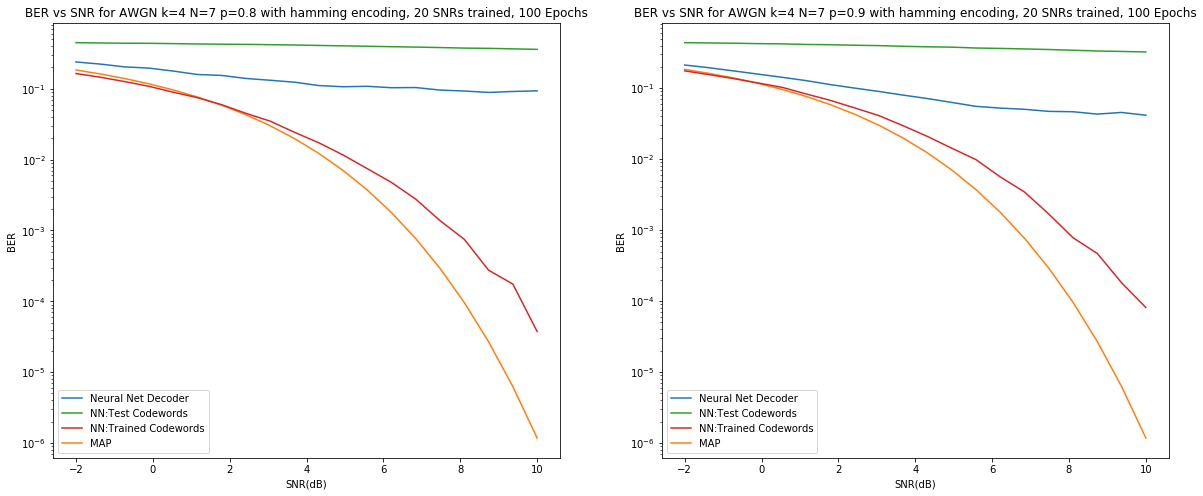

In [33]:
fig = plt.figure(figsize=(20,8))
plt.subplot(121);
subsetCodewords1.plotBER();
plt.subplot(122)
subsetCodewords2.plotBER();

The blue line is tested with all codewords and is not close to the MAP decoding BER. The decoding for the trained codewords (red) is close to the MAP BER but the decoding for the untrained or test codewords (green) is almost completely random. This suggests that neural network decoder does not generalize to untrained codewords for a Hamming encoder. 

## OFDM Channel Tests

The signal is now sent through an OFDM module and then to the neural net. This adds significant complexity as the signals are sent over different frequency carriers through a channel which has a finite impulse response and adds noise. The cyclic prefix length is also suboptimal (7 instead of 9) so there will be inter-symbol interference.

Each new set of neural network inputs has gone through different frequency subcarriers than the last. This is because the neural network only takes in 14 inputs corresponding to a particular codeword (real and imaginary parts) but the OFDM module puts out 32 outputs, each on different frequency subcarriers. To decode successfully it has to be able to learn how the frequency response changes as its inputs are fed in. 

For the OFDM training, using high ```Mblocks``` is more effective than increasing the number of SNR trained. This is because the neural net needs a long stream of data to have enough information to learn the channel complexities for each SNR.

In [34]:
%%time
OFDMlowBlocks = NNdecoder(channel_type='OFDM',Mblocks=50);
OFDMlowBlocks.run();

Training...Testing...Complete
Wall time: 32.9 s


In [35]:
%%time
OFDMmedM =  NNdecoder(channel_type='OFDM',Mblocks=200);
OFDMmedM.run()

Training...Testing...Complete
Wall time: 1min 14s


In [36]:
%%time
OFDMhighM = NNdecoder(channel_type='OFDM',Mblocks=1000);
OFDMhighM.run();

Training...Testing...Complete
Wall time: 4min 52s


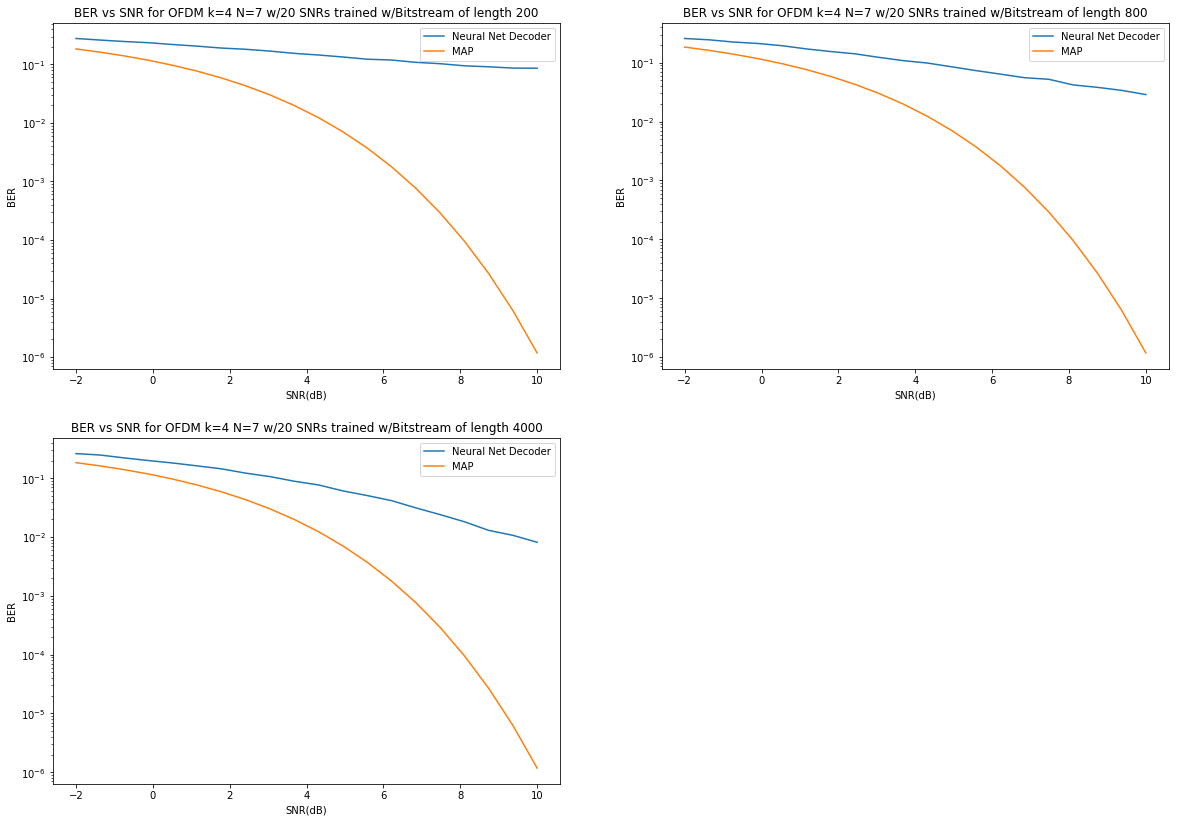

In [37]:
fig = plt.figure(figsize=(20,14))
plt.subplot(221);
OFDMlowBlocks.plotBER();
plt.subplot(222)
OFDMmedM.plotBER();
plt.subplot(223)
OFDMhighM.plotBER();

The decoder performance when the signal is sent through an OFDM is far from the MAP BER.

### Simplified OFDM Module
The tests were now run on an OFDM module with only 7 carriers, a finite impulse response with 5 taps, and a cyclic prefix of length 4.

![](/images/OFDMsimpleBER.png)

As the plot show, the neural net decoder achieves MAP BER performance for this very simplified OFDM channel. 
This makes sense since the OFDM output now becomes equivalent to 7 different AWGN channels whose complex number outputs go to the same 2 inputs of the neural networks each time (since it has 14 inputs). 

However, for a neural network to be truly useful it should be able to achieve high performance even for complex channels.

## Send String Message

The communication system is now tested by sending a message string  converted to bits through the channel and then converting back to a string.

```python
def sendStringMessage(self,msg_str,sendEbN0=10):
```
Send a message string over a channel with the inputted SNR


If an error like this occurs
```python
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xee in position 2: invalid continuation byte
```
It is because a bit error occurred in one of the necessary bits for the unicode to convert from bytes to string.
Running the test multiple times and/or increasing the SNR should eventually give a successful output. This is especially a problem if the OFDM channel is used since its bit error rate is much higher so it should be run with a high ```sendEbN0```

In [63]:
%%time
combineDecoder.sendStringMessage("Send any message here",10)

Total Message Bits = 168
Bit Errors = 0.0

Transmitted:
Send any message here

Recieved:
Send any message here

Wall time: 11 ms


In [64]:
%%time
OFDMhighM.sendStringMessage("Send any message here",10)

Total Message Bits = 168
Bit Errors = 1.0

Transmitted:
Send any message here

Recieved:
Send an} message here

Wall time: 7.94 ms


# Conclusion

For the AWGN channel the Neural Network decoder performance was as good as the MAP decoder. However, it does not successfully generalize to untrained codewords when using a Hamming encoder.

The performance was significantly lower when the signal was sent through the original OFDM. One source of error comes from the cyclic prefix being too small leading to intersymbol interference. An additional source of error is that any particular codeword bit gets sent over different frequency subcarriers each time it is passed as an input to the network adding further complexity to the decoding.

With both of these error sources removed by simplifying the OFDM module, the decoder performed as well as a MAP decoder.

In practice the neural network decoder should be able to work even on a channel with high complexity. One possibility may be to use a recurrent neural network since it has memory which should allow it to decode both of the mentioned channel complexities more effectively.

Another option may be to improve the design of the current system. A tag could be sent indicating the particular frequency subcarriers the neural network's current inputs were sent on allowing it to use that information to improve decoding. The number of inputs to the neural network could also be adjusted.

# Citations

Guidance on basic structure of a neural network decoder from 

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }
    
    
```text_to_bits``` and ```text_from_bits``` were both found on https://stackoverflow.com/questions/10237926/convert-string-to-list-of-bits-and-viceversa/10238140 


scikit-dsp-comm package found here
https://github.com/mwickert/scikit-dsp-comm/blob/master/README.md